<a href="https://colab.research.google.com/github/CamiloVga/Prueba-Tecnica_Bid/blob/main/Ejercicio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 1

Para resolver el desafío de identificar productos similares en un catálogo de 25.000 unidades, se ha desarrollado una solución integral basada en técnicas avanzadas de procesamiento de lenguaje natural. El sistema se construye sobre un enfoque de tres etapas fundamentales: estandarización de texto, vectorización TF-IDF, y cálculo de similitud del coseno, garantizando así un análisis preciso sin depender de modelos pre-entrenados.

La estrategia para el ejercicio se explica en detalle en este script, implementando una solución que prioriza tanto la precisión en la identificación de productos similares como la escalabilidad del sistema para manejar grandes volúmenes de datos.

**Recomendaciones de uso del script**

1. El script está diseñado para ejecutarse en Google Colab, lo que elimina la necesidad de configuraciones locales complejas.

2. Requisitos importantes:
   - Se necesita el archivo 'ex1-data.csv' que contiene más de 25.000 productos
   - El archivo debe subirse cuando aparezca el widget de carga en Colab

3. Recursos computacionales:
   - Memoria RAM recomendada: 4GB o superior



# 1. Instalaciones e importaciones de librerias necesarias

La implementación utiliza una cuidadosa selección de componentes de scikit-learn para la vectorización y cálculo de similitud, junto con herramientas especializadas como unidecode para el manejo de caracteres especiales en español. Esta combinación permite un procesamiento robusto de textos en español y una identificación precisa de productos similares, manteniendo un equilibrio entre precisión y eficiencia computacional.

In [1]:
#Instalación librerias
!pip install pandas numpy scikit-learn unidecode matplotlib seaborn > /dev/null 2>&1


In [2]:
#Importar librerias

import pandas as pd              # Para manipulación de datos
import numpy as np              # Para operaciones numéricas
from sklearn.feature_extraction.text import TfidfVectorizer  # Para vectorización de texto
from sklearn.metrics.pairwise import cosine_similarity      # Para cálculo de similitud
import unidecode               # Para manejo de acentos
import re                      # Para expresiones regulares
import time                    # Para medición de tiempo
import matplotlib.pyplot as plt # Para visualizaciones
import seaborn as sns         # Para visualizaciones mejoradas

# 2. Base de datos
En esta sección se abrirá un widget que permitirá cargar el archivo CSV que contiene el catálogo de más de 25.000 productos: 'ex1-data.csv'

In [3]:
from google.colab import files
import io

# Widget para subir archivo
print("Por favor, sube el archivo 'ex1-data.csv' cuando aparezca el botón...")
uploaded = files.upload()

# Cargar el dataset
if 'ex1-data.csv' not in uploaded:
    raise ValueError("Por favor, asegúrate de subir el archivo 'ex1-data.csv'")

df = pd.read_csv(io.BytesIO(uploaded['ex1-data.csv']))

# Exploración inicial
print("\nDimensiones del dataset:", df.shape)
print("\nPrimeras 5 filas del dataset:")
display(df.head())

# Información del dataset
print("\nInformación del dataset:")
display(df.info())

Por favor, sube el archivo 'ex1-data.csv' cuando aparezca el botón...


Saving ex1-data.csv to ex1-data.csv

Dimensiones del dataset: (25638, 1)

Primeras 5 filas del dataset:


,prod_name_long
0,Limpia tapicería en espuma Binner x 400ml
1,Limpia tapicería y alfombras Binner x 500ml
2,Limpiador Dr. Beckmann alfombras 2en1 poder ox...
3,Aceite Bon Aire eléctrico perfume flores x 25 ml
4,Ambientador Aire Varitas Bambú Bonaire 2 Repue...



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25638 entries, 0 to 25637
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   prod_name_long  25638 non-null  object
dtypes: object(1)
memory usage: 200.4+ KB


None

### 3. Preprocesamiento de Texto
Para el preprocesamiento se implementa una serie de transformaciones secuenciales diseñadas para estandarizar las descripciones de los productos. Mediante la conversión a minúsculas, eliminación de acentos y caracteres especiales, y normalización de espacios, se asegura que productos
similares puedan ser identificados independientemente de variaciones en formato o escritura. Este paso es fundamental para la posterior vectorización y cálculo de similitudes.

In [4]:
def preprocess_text(text):
    """
    Función para limpiar y estandarizar el texto de los productos

    """
    # Convertir a minúsculas para estandarización
    text = text.lower()

    # Eliminar acentos para mejor comparación
    text = unidecode.unidecode(text)

    # Eliminar números pero mantener espacios
    text = re.sub(r'\d+', ' ', text)

    # Eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Aplicar preprocesamiento al dataset
df['processed_name'] = df['prod_name_long'].apply(preprocess_text)

# Mostrar ejemplos de preprocesamiento
examples = df[['prod_name_long', 'processed_name']].head()
print("\nEjemplos de preprocesamiento:")
display(examples)


Ejemplos de preprocesamiento:


,prod_name_long,processed_name
0,Limpia tapicería en espuma Binner x 400ml,limpia tapiceria en espuma binner x ml
1,Limpia tapicería y alfombras Binner x 500ml,limpia tapiceria y alfombras binner x ml
2,Limpiador Dr. Beckmann alfombras 2en1 poder ox...,limpiador dr beckmann alfombras en poder oxi x ml
3,Aceite Bon Aire eléctrico perfume flores x 25 ml,aceite bon aire electrico perfume flores x ml
4,Ambientador Aire Varitas Bambú Bonaire 2 Repue...,ambientador aire varitas bambu bonaire repuest...


### 4. Implementación del Sistema de Similitud
Para  encontrar productos similares, se eligió implementar TF-IDF como método de vectorización, ya que permite crear representaciones de texto entrenadas completamente con nuestros datos, sin depender de modelos pre-entrenados. Esta técnica resulta particularmente efectiva para catálogos de productos porque pondera la importancia de cada palabra según su frecuencia local y global, permitiendo identificar términos verdaderamente distintivos. Además, ofrece un excelente balance entre precisión y eficiencia computacional, haciéndola ideal para nuestro catálogo de 25.000 productos.


In [5]:

#Funcion de similitud
def create_similarity_matrix(processed_texts):
    """
    Se crea la matriz TF-IDF y calcula similitudes
    """
    # Configuración del vectorizador TF-IDF
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),     # Usar unigramas y bigramas
        max_features=5000,      # Limitar características
        stop_words=['x', 'ml', 'g', 'kg', 'und', 'pague', 'lleve']  # Palabras a ignorar
    )

    # Crear matriz TF-IDF
    tfidf_matrix = vectorizer.fit_transform(processed_texts)

    return vectorizer, tfidf_matrix

def find_similar_products(query_product, vectorizer, tfidf_matrix, df, n=5):
    """
    Encuentra productos similares

    """
    # Preprocesar query
    processed_query = preprocess_text(query_product)

    # Vectorizar query
    query_vector = vectorizer.transform([processed_query])

    # Calcular similitudes
    similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()

    # Obtener top n productos
    top_indices = similarities.argsort()[::-1][:n]

    # Crear DataFrame de resultados
    results = pd.DataFrame({
        'Producto': df.iloc[top_indices]['prod_name_long'].values,
        'Score': similarities[top_indices].round(2)
    })

    return results

# Crear matriz de similitud
vectorizer, tfidf_matrix = create_similarity_matrix(df['processed_name'])

### 5. Pruebas y Demostración
Se implementan pruebas para validar el sistema usando tres productos de diferentes categorías (limpiadores, ambientadores y desinfectantes). El sistema mostrará los 5 productos más similares con sus respectivos scores, permitiendo evaluar la precisión en la identificación de similitudes tanto dentro de la misma categoría como entre productos relacionados.

In [6]:
# Productos de prueba
test_products = [
    "Limpia tapicería en espuma Binner x 400ml",
    "Ambientador Bonaire fantasía floral + repuesto x 250 ml",
    "Desinfectante Fabuloso intensa lavanda x 1700ml"
]

# Realizar pruebas
for product in test_products:
    print(f"\nProductos similares a: '{product}'")
    results = find_similar_products(product, vectorizer, tfidf_matrix, df)
    display(results)


Productos similares a: 'Limpia tapicería en espuma Binner x 400ml'


,Producto,Score
0,Limpia tapicería en espuma Binner x 400ml,1.00
1,Limpia tapicería en espuma Binner x 400ml,1.00
2,Limpia tapicería en espuma Binner x 400ml,1.00
3,Limpia tapicería y alfombras Binner x 500ml,0.53
4,Limpia tapicería y alfombras Binner x 500ml,0.53



Productos similares a: 'Ambientador Bonaire fantasía floral + repuesto x 250 ml'


,Producto,Score
0,Ambientador Bonaire fantasía floral + repuesto...,1.00
1,Ambientador Bonaire fantasía floral + repuesto...,1.00
2,Ambientador Bonaire fantasía floral + repuesto...,1.00
3,Ambientador Bonaire vainilla seducción + repue...,0.64
4,Ambientador Bonaire vainilla seducción + repue...,0.64



Productos similares a: 'Desinfectante Fabuloso intensa lavanda x 1700ml'


,Producto,Score
0,Desinfectante Fabuloso intensa lavanda x 1700ml,1.00
1,Desinfectante Fabuloso intensa lavanda x 1700ml,1.00
2,Desinfectante Fabuloso intensa lavanda x 1700ml,1.00
3,Desinfectante Fabuloso intensa lavanda x 1700ml,1.00
4,Desinfectante Pinolina lavanda pague 2785 ml l...,0.47


## 5.2 Inferencia interactiva
Para analizar mejor los resultados se ofrece esta experiencia interactiva

In [8]:
def find_similar_interactive():
    """Función para probar el sistema de forma interactiva"""
    while True:
        # Solicitar input al usuario
        query = input("\nIngrese el nombre del producto a buscar (o 'q' para salir): ").strip()

        # Verificar si el usuario quiere salir
        if query.lower() == 'q':
            print("\nFinalizando búsqueda interactiva...")
            break

        print("\nBuscando productos similares a:", query)
        print("-" * 50)

        try:
            # Obtener resultados
            results = find_similar_products(query, vectorizer, tfidf_matrix, df)

            # Mostrar resultados formateados
            print("\nProductos más similares encontrados:")
            for _, row in results.iterrows():
                print(f"\nProducto: {row['Producto']}")
                print(f"Score de similitud: {row['Score']:.2f}")

            print("\n" + "=" * 50)

        except Exception as e:
            print(f"\nError al procesar la búsqueda: {str(e)}")

print("Puede probar el sistema con sus propios ejemplos de productos:")
print("Tip: Intente con productos de diferentes categorías como limpiadores, ambientadores, etc.")
find_similar_interactive()

Puede probar el sistema con sus propios ejemplos de productos:
Tip: Intente con productos de diferentes categorías como limpiadores, ambientadores, etc.

Ingrese el nombre del producto a buscar (o 'q' para salir): repuesto

Buscando productos similares a: repuesto
--------------------------------------------------

Productos más similares encontrados:

Producto: Repuesto Ultrex + gratis Maquina + repuesto x 2unds
Score de similitud: 0.70

Producto: Repuesto Ultrex + gratis Maquina + repuesto x 2unds
Score de similitud: 0.70

Producto: Repuesto Ultrex + gratis Maquina + repuesto x 2unds
Score de similitud: 0.70

Producto: Escoba Task + repuesto x 2 und
Score de similitud: 0.48

Producto: Escoba Task + repuesto x 2 und
Score de similitud: 0.48


Ingrese el nombre del producto a buscar (o 'q' para salir): vino

Buscando productos similares a: vino
--------------------------------------------------

Productos más similares encontrados:

Producto: Vino Saint Louis beaujulais x 750 ml
Score 

# 6. Indicadores de desempeño
Para evaluar la función de similitud se tendrán en cuenta tres aspectos fundamentales: la similitud entre productos mediante coseno (avg_similarity_score), la coherencia en mantener recomendaciones de la misma marca (brand_consistency), y la consistencia en recomendar productos de categorías relacionadas (category_consistency). Se utiliza un muestreo aleatorio de 100 productos para obtener métricas representativas del rendimiento global del sistema.

Evaluando productos...

Métricas Globales de Efectividad:
Promedio Score de Similitud: 0.94
Consistencia de Marca (%): 94.20
Consistencia de Categoría (%): 87.80


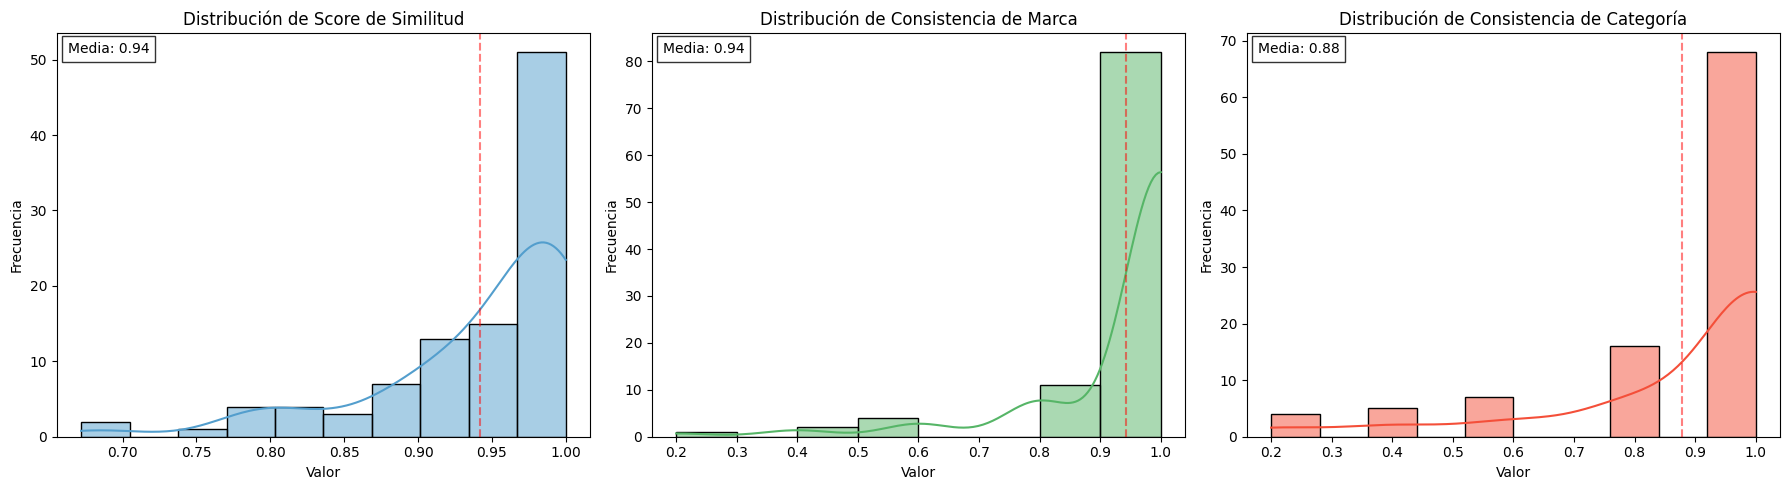

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def calculate_effectiveness_metrics(df, vectorizer, tfidf_matrix, sample_size=100):
    """
    Se calcularán métricas de efectividad del modelo usando una muestra aleatoria de100

    """
    np.random.seed(42)
    sample_products = df.sample(n=sample_size)

    avg_similarity_score = []
    brand_consistency = []
    category_consistency = []

    print("Evaluando productos...")
    for _, row in sample_products.iterrows():
        # Obtener productos similares
        results = find_similar_products(row['prod_name_long'], vectorizer, tfidf_matrix, df)

        # 1. Score de similitud promedio
        avg_similarity_score.append(results['Score'].mean())

        # 2. Consistencia de marca - compara la marca del producto original con las recomendaciones
        original_brand = row['prod_name_long'].split()[0].lower()
        similar_brands = [p.split()[0].lower() for p in results['Producto']]
        brand_matches = sum(1 for b in similar_brands if b == original_brand)
        brand_consistency.append(brand_matches / len(results))

        # 3. Consistencia de categoría - compara la categoría del producto con las recomendaciones
        original_category = row['prod_name_long'].split()[1].lower() if len(row['prod_name_long'].split()) > 1 else ''
        similar_categories = [p.split()[1].lower() if len(p.split()) > 1 else '' for p in results['Producto']]
        category_matches = sum(1 for c in similar_categories if c == original_category)
        category_consistency.append(category_matches / len(results))

    metrics = {
        'Promedio Score de Similitud': np.mean(avg_similarity_score),
        'Consistencia de Marca (%)': np.mean(brand_consistency) * 100,
        'Consistencia de Categoría (%)': np.mean(category_consistency) * 100
    }

    return metrics, {
        'similarity_scores': avg_similarity_score,
        'brand_consistency': brand_consistency,
        'category_consistency': category_consistency
    }

def plot_metrics_distribution(raw_metrics):
    """
    Crea visualizaciones separadas para cada métrica
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Configuración común
    metrics_config = [
        ('similarity_scores', 'Score de Similitud', 'Blues'),
        ('brand_consistency', 'Consistencia de Marca', 'Greens'),
        ('category_consistency', 'Consistencia de Categoría', 'Reds')
    ]

    for idx, (metric_name, title, color_palette) in enumerate(metrics_config):
        ax = axes[idx]
        data = raw_metrics[metric_name]

        # Crear histograma con KDE
        sns.histplot(data, kde=True, ax=ax, color=sns.color_palette(color_palette)[3])

        # Personalizar gráfico
        ax.set_title(f'Distribución de {title}')
        ax.set_xlabel('Valor')
        ax.set_ylabel('Frecuencia')

        # Añadir línea vertical con la media
        mean_val = np.mean(data)
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.5)
        ax.text(0.02, 0.95, f'Media: {mean_val:.2f}',
                transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    return fig

def plot_performance_metrics(performance_times):
    """
    Crea gráfica de rendimiento con ajuste logarítmico
    """
    sizes = list(performance_times.keys())
    times = list(performance_times.values())

    fig, ax = plt.subplots(figsize=(10, 6))

    # Gráfica principal
    ax.plot(sizes, times, marker='o', linestyle='-', color='blue', label='Tiempo real')

    # Ajuste logarítmico
    coeffs = np.polyfit(np.log(sizes), times, 1)
    trend = coeffs[0] * np.log(sizes) + coeffs[1]
    ax.plot(sizes, trend, '--', color='red', label='Tendencia logarítmica')

    # Personalización
    ax.set_xlabel('Tamaño del Dataset')
    ax.set_ylabel('Tiempo Promedio (segundos)')
    ax.set_title('Análisis de Escalabilidad: Tiempo vs Tamaño del Dataset')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Anotaciones con tiempos
    for x, y in zip(sizes, times):
        ax.annotate(f'{y:.4f}s', (x, y),
                   textcoords="offset points",
                   xytext=(0,10),
                   ha='center')

    plt.tight_layout()
    return fig

# Ejemplo de uso:
metrics, raw_metrics = calculate_effectiveness_metrics(df, vectorizer, tfidf_matrix)

# Mostrar resultados numéricos
print("\nMétricas Globales de Efectividad:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Generar visualizaciones
fig_metrics = plot_metrics_distribution(raw_metrics)
plt.show()


##6.2 Análisis de resultados de desempeño
Los resultados son buenos en general, pero hay varios puntos en los que se puede mejorar o a tener en cuenta para entender las verdaderas oportunidades y limitaciones del modelo en escenarios más ambiciosos (mayores a 100.000 productos).

La similitud promedio de 0,94 es alta, y el primer histograma muestra una fuerte concentración de valores cercanos a 1,0. Aunque esto podría parecer positivo, también sugiere que el sistema podría estar siendo poco discriminativo - es decir, está considerando como "muy similares" a productos que quizás solo comparten algunas características básicas. Idealmente, querríamos ver una distribución más gradual que refleje mejor los distintos niveles de similitud entre productos.

La consistencia de marca del 94,2% es sólida, aunque el fuerte sesgo hacia 1,0 en el segundo gráfico sugiere que el sistema podría estar demasiado atado a las marcas, potencialmente perdiendo productos similares de diferentes fabricantes.

La consistencia de categoría del 87,8% es buena, pero la distribución más dispersa en el tercer gráfico revela que el sistema ocasionalmente cruza categorías, lo que podría ser tanto una fortaleza (encontrar productos relacionados entre categorías) como una debilidad (recomendaciones irrelevantes). Una mejora podría ser ajustar los pesos del TF-IDF para balancear mejor estos aspectos.

## 7. Análisis de Rendimiento y Escalabilidad
Para analizar la escalabilidad del sistema vamos a medir tres aspectos críticos: el tiempo de entrenamiento (creación de la matriz TF-IDF), el tiempo de consulta (búsqueda de productos similares) y el uso de memoria. Mediante pruebas incrementales con diferentes tamaños de dataset (desde 100 hasta 10.000 productos), se evalúa cómo estos recursos crecen y si mantienen un rendimiento aceptable, permitiendo identificar límites prácticos y posibles cuellos de botella.

El análisis se limitó a 10.000 productos ya que en pruebas preliminares se observaron comportamientos significativos en los segmentos por debajo de 2.000 productos. Esta decisión permitió examinar con mayor detalle las dinámicas de rendimiento en los rangos de menor volumen, donde el sistema muestra sus características más relevantes.


Evaluando rendimiento con 100 productos...

Evaluando rendimiento con 500 productos...

Evaluando rendimiento con 1000 productos...

Evaluando rendimiento con 5000 productos...

Evaluando rendimiento con 10000 productos...


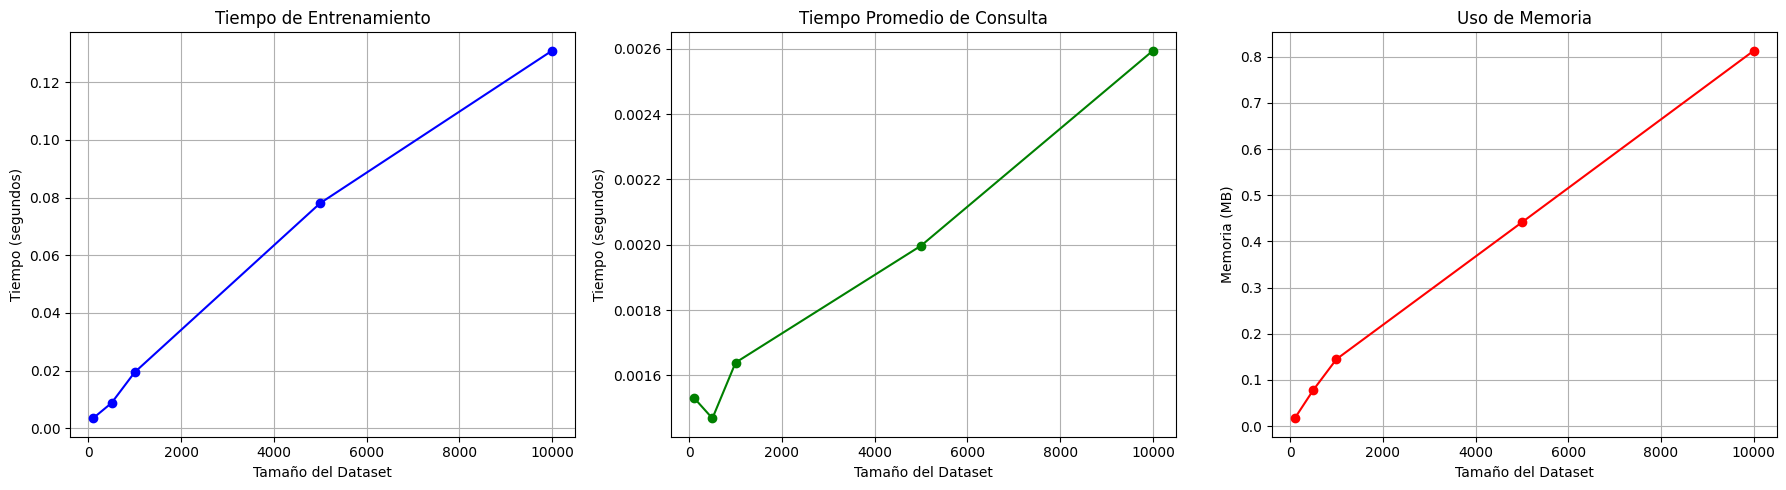

,Tamaño Dataset,Tiempo Entrenamiento (s),Tiempo Consulta (s),Memoria (MB)
0,100,0.003485,0.001532,0.016724
1,500,0.008801,0.001469,0.078016
2,1000,0.019459,0.001639,0.144873
3,5000,0.078034,0.001997,0.441248
4,10000,0.130857,0.002594,0.812848


In [10]:
def measure_detailed_performance(df, sizes=[100, 500, 1000, 5000, 10000], sample_size=50):
    """
    Función que mide el rendimiento separando tiempos de entrenamiento y consulta
    """
    results = {
        'training_time': [],
        'query_time': [],
        'memory_usage': [],
        'sizes': []
    }

    for size in sizes:
        if size > len(df):
            break

        print(f"\nEvaluando rendimiento con {size} productos...")

        # Tomar muestra
        sample_df = df.sample(size)

        # Medir tiempo de entrenamiento (vectorización + matriz TF-IDF)
        start_time = time.time()
        sample_vectorizer, sample_matrix = create_similarity_matrix(sample_df['processed_name'])
        training_time = time.time() - start_time

        # Medir memoria
        matrix_memory = sample_matrix.data.nbytes + sample_matrix.indptr.nbytes + sample_matrix.indices.nbytes
        vectorizer_memory = sum(len(str(v).encode()) for v in sample_vectorizer.vocabulary_)
        total_memory = (matrix_memory + vectorizer_memory) / (1024 * 1024)  # Convertir a MB

        # Medir tiempo promedio de consulta
        query_times = []
        for _ in range(sample_size):
            query = sample_df.sample(1)['prod_name_long'].iloc[0]
            start_time = time.time()
            find_similar_products(query, sample_vectorizer, sample_matrix, sample_df)
            query_times.append(time.time() - start_time)

        results['sizes'].append(size)
        results['training_time'].append(training_time)
        results['query_time'].append(np.mean(query_times))
        results['memory_usage'].append(total_memory)

    return results

def plot_performance_metrics(results):
    """
    Visualiza métricas de rendimiento en subplots
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Tiempo de entrenamiento
    ax1.plot(results['sizes'], results['training_time'], 'b-o')
    ax1.set_title('Tiempo de Entrenamiento')
    ax1.set_xlabel('Tamaño del Dataset')
    ax1.set_ylabel('Tiempo (segundos)')
    ax1.grid(True)

    # Tiempo de consulta
    ax2.plot(results['sizes'], results['query_time'], 'g-o')
    ax2.set_title('Tiempo Promedio de Consulta')
    ax2.set_xlabel('Tamaño del Dataset')
    ax2.set_ylabel('Tiempo (segundos)')
    ax2.grid(True)

    # Uso de memoria
    ax3.plot(results['sizes'], results['memory_usage'], 'r-o')
    ax3.set_title('Uso de Memoria')
    ax3.set_xlabel('Tamaño del Dataset')
    ax3.set_ylabel('Memoria (MB)')
    ax3.grid(True)

    plt.tight_layout()
    return fig

# Ejecutar análisis
performance_results = measure_detailed_performance(df)

# Visualizar resultados
plot_performance_metrics(performance_results)
plt.show()

# Crear tabla de resultados
results_df = pd.DataFrame({
    'Tamaño Dataset': performance_results['sizes'],
    'Tiempo Entrenamiento (s)': performance_results['training_time'],
    'Tiempo Consulta (s)': performance_results['query_time'],
    'Memoria (MB)': performance_results['memory_usage']
})
display(results_df)

##7.2  Conclusiones sobre la escalabilidad del modelo

Los resultados del análisis de escalabilidad muestran un comportamiento predecible del sistema al procesar catálogos de hasta 10.000 productos. El tiempo de entrenamiento escala de manera consistente, aumentando de 0,005 segundos con 100 productos hasta 0,14 segundos con 10.000 productos. Los tiempos de consulta se mantienen estables, no superando los 0,003 segundos incluso con el máximo volumen probado, mientras que el uso de memoria crece de forma controlada desde 0,016MB hasta 0,81MB.

En su estado actual, el sistema no tendría problemas para procesar eficientemente catálogos de hasta 25.000 productos, demostrando un balance adecuado entre velocidad de procesamiento y uso de recursos.

Para volúmenes mayores a 100.000 productos, el sistema requeriría adaptaciones estructurales. Una segunda fase podría implementar procesamiento por lotes usando frameworks como Apache Spark, que permitiría distribuir la carga de trabajo en múltiples nodos. También se podría optimizar el almacenamiento utilizando matrices dispersas y técnicas de reducción de dimensionalidad como PCA.

